In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, classification_report 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample 

In [30]:
# set matplotlib defaults
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (15,6)
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rc('figure', titlesize=18)
plt.style.use('seaborn-darkgrid')

In [44]:
data = pd.read_csv("../data/dataset_2019_with_negatives.csv")

In [46]:
data = data.drop(columns=['year', 'precipAccumulation'])

In [47]:
boroughs = pd.read_csv("../data/localidades.csv")

In [48]:
data = data.merge(boroughs[['id', 'borough']], left_on='borough', right_on='borough')
data.rename(columns={"id": 'borough_id'}, inplace=True)
data.head()

,x,y,timestamp,date,month,day,day_of_year,hour,address,severity,...,windSpeed,windBearing,cloudCover,uvIndex,visibility,pressure,windGust,precipType,ozone,borough_id
0,-74.134363,4.579297,2019-01-11 14:20:00,2019-01-11,1,11,11,14,KR 26-CL 52B S 2,Injury,...,1.66,167.0,0.89,4.0,13.489,1018.0,1.66,rain,239.8,6
1,-74.139488,4.573233,2019-01-11 14:00:00,2019-01-11,1,11,11,14,AV AVENIDA BOYACA-KR 24 2,NaN,...,1.66,167.0,0.89,4.0,13.489,1018.0,1.66,rain,239.8,6
2,-74.135804,4.588874,2019-01-11 17:38:00,2019-01-11,1,11,11,17,CL 49A-KR 37 S 2,Injury,...,1.90,225.0,0.95,7.0,12.000,1016.3,2.17,rain,237.6,6
3,-74.123576,4.558440,2019-01-11 17:00:00,2019-01-11,1,11,11,17,CL 52-KR 10A S 2,NaN,...,1.90,225.0,0.95,7.0,12.000,1016.3,2.17,rain,237.6,6
4,-74.138016,4.566990,2019-01-24 12:00:00,2019-01-24,1,24,10,12,AV AVENIDA BOYACA-KR 19C 2,Injury,...,3.37,129.0,0.67,0.0,15.142,1016.2,5.20,rain,240.4,6


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174354 entries, 0 to 174353
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   x                    174354 non-null  float64
 1   y                    174354 non-null  float64
 2   timestamp            174354 non-null  object 
 3   date                 174354 non-null  object 
 4   month                174354 non-null  int64  
 5   day                  174354 non-null  int64  
 6   day_of_year          174354 non-null  int64  
 7   hour                 174354 non-null  int64  
 8   address              174354 non-null  object 
 9   severity             29053 non-null   object 
 10  accident_type        29053 non-null   object 
 11  severity_numeric     29053 non-null   float64
 12  borough              174354 non-null  object 
 13  cluster_id           174354 non-null  int64  
 14  sample_type          174354 non-null  int64  
 15  area_km2         

In [61]:
data.severity_numeric = data.severity_numeric.fillna(0)

In [49]:
corr = data.corr()
c1 = corr.abs().unstack().round(3)
c1<1
c1[(c1<1) & (c1> 0.65)].sort_values(ascending = False)

apparentTemperature  temperature            0.998
temperature          apparentTemperature    0.998
                     uvIndex                0.835
uvIndex              temperature            0.835
day_of_year          month                  0.834
month                day_of_year            0.834
windSpeed            windGust               0.828
windGust             windSpeed              0.828
apparentTemperature  uvIndex                0.826
uvIndex              apparentTemperature    0.826
precipProbability    precipIntensity        0.786
precipIntensity      precipProbability      0.786
temperature          hour                   0.698
hour                 temperature            0.698
apparentTemperature  hour                   0.691
hour                 apparentTemperature    0.691
apparentTemperature  dewPoint               0.679
dewPoint             apparentTemperature    0.679
                     temperature            0.666
temperature          dewPoint               0.666


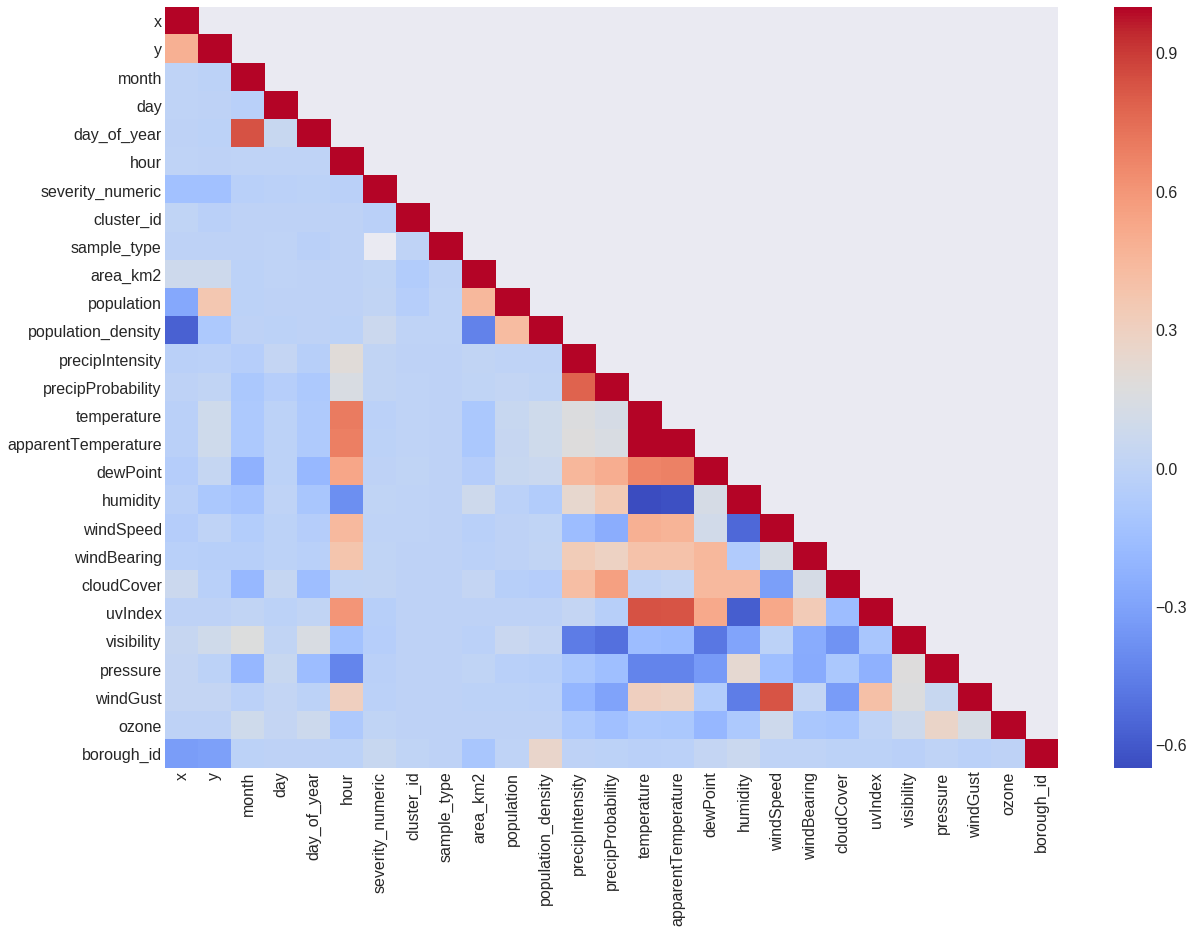

In [50]:
plt.figure(figsize=(20,14))
sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)), cmap='coolwarm',annot_kws={"size":10})
plt.show()

In [53]:
corr.columns

Index(['x', 'y', 'month', 'day', 'day_of_year', 'hour', 'severity_numeric',
       'cluster_id', 'sample_type', 'area_km2', 'population',
       'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'windGust', 'ozone', 'borough_id'],
      dtype='object')

In [63]:
feature_columns_model_1 = ['x', 'y', 'month', 'day', 'day_of_year', 'hour', 'severity_numeric',
       'cluster_id', 'area_km2', 'population',
       'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'windGust', 'ozone', 'borough_id']
X = data[feature_columns_model_1]
y = data.sample_type

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [92]:
from sklearn.naive_bayes import GaussianNB
categories = ['accident', 'non-accident']
nb = GaussianNB()
nb.fit(X_train, y_train)
scores = cross_val_score(nb, X_train, y_train, cv=5, scoring= 'f1_weighted')
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.76 (+/- 0.000 )


In [93]:
y_pred = nb.predict(X_test)
print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test,labels=y.unique())))
print(classification_report(y_test, y_pred,target_names=categories))


Cohen kappa score 0.00
              precision    recall  f1-score   support

    accident       0.83      1.00      0.91     48016
non-accident       0.00      0.00      0.00      9521

    accuracy                           0.83     57537
   macro avg       0.42      0.50      0.45     57537
weighted avg       0.70      0.83      0.76     57537



In [94]:
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=3)
scv = StratifiedKFold(n_splits=3)
clf = GaussianNB()
for metric in metric_names:
    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

In [95]:
scores_df

,Random-CV,Stratified-CV
f1,0,0
roc_auc,0.737173,0.738336
average_precision,0.507623,0.511397
accuracy,0.832773,0.832773
precision,0,0
recall,0,0


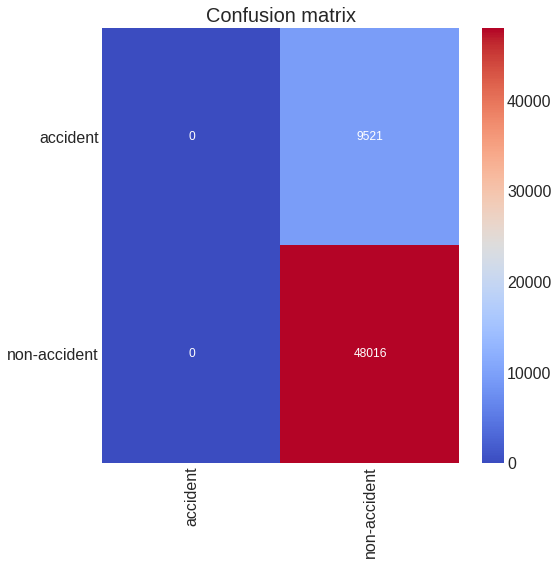

In [106]:
cnf_mx = confusion_matrix(y_test,y_pred,labels=y.unique())
plt.figure(figsize=(8,8))
sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Confusion matrix', fontsize=20)
plt.show()

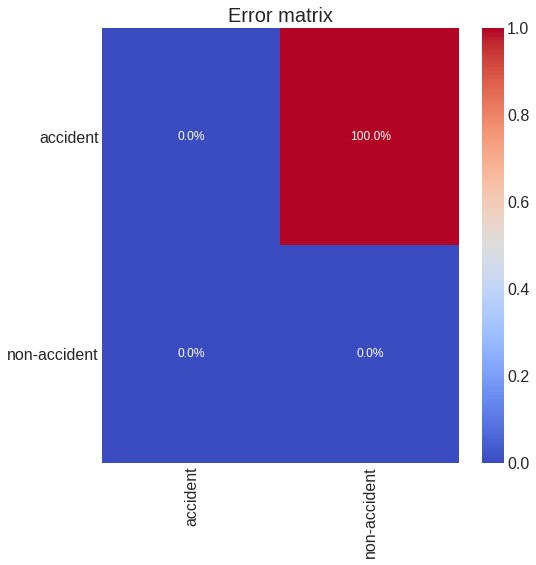

In [113]:
row_sums = cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = cnf_mx / row_sums
np.fill_diagonal(norm_cnf_mx, 0)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".1%")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Error matrix', fontsize=20)
plt.show()

In [123]:
# Separate majority and minority classes
df_majority = data[data.sample_type==0]
df_minority = data[data.sample_type==1]
print(df_majority.shape, df_minority.shape)

(145301, 37) (29053, 37)


In [134]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=29053*5,    # to match majority class
                                 )
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.sample_type.value_counts()

0    145301
1    145265
Name: sample_type, dtype: int64

In [135]:
X = df_upsampled[feature_columns_model_1]
y = df_upsampled.sample_type

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [137]:
categories = ['accident', 'non-accident']
nb = GaussianNB()
nb.fit(X_train, y_train)
scores = cross_val_score(nb, X_train, y_train, cv=5, scoring= 'f1_weighted')
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.68 (+/- 0.008 )


In [138]:
y_pred = nb.predict(X_test)
print('Cohen kappa score {:.2f}'.format(cohen_kappa_score(y_pred, y_test,labels=y.unique())))
print(classification_report(y_test, y_pred,target_names=categories))


Cohen kappa score 0.39
              precision    recall  f1-score   support

    accident       0.63      0.96      0.76     48092
non-accident       0.91      0.44      0.59     47795

    accuracy                           0.70     95887
   macro avg       0.77      0.70      0.67     95887
weighted avg       0.77      0.70      0.67     95887



In [139]:
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=3)
scv = StratifiedKFold(n_splits=3)
clf = GaussianNB()
for metric in metric_names:
    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

In [140]:
scores_df

,Random-CV,Stratified-CV
f1,0.599347,0.598287
roc_auc,0.759134,0.759132
average_precision,0.814079,0.814026
accuracy,0.697512,0.696742
precision,0.889921,0.888227
recall,0.452519,0.45138


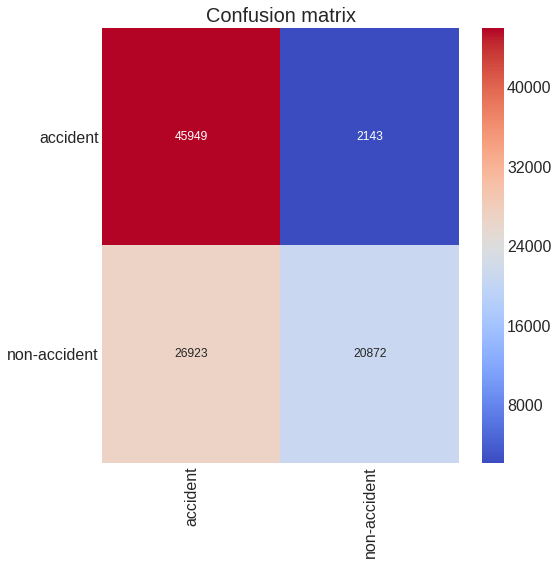

In [141]:
cnf_mx = confusion_matrix(y_test,y_pred,labels=y.unique())
plt.figure(figsize=(8,8))
sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Confusion matrix', fontsize=20)
plt.show()

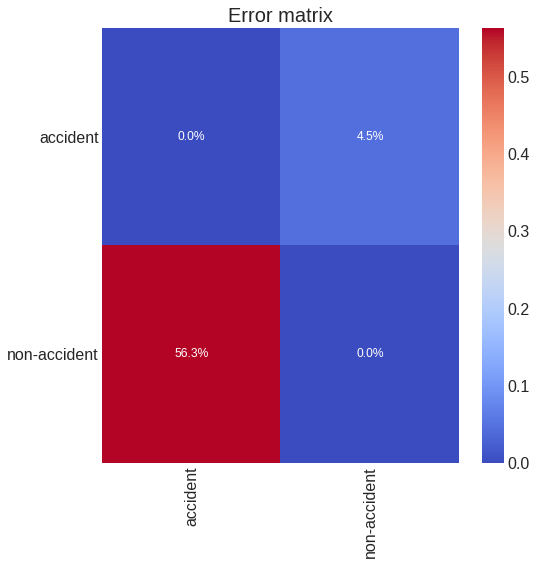

In [142]:
row_sums = cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = cnf_mx / row_sums
np.fill_diagonal(norm_cnf_mx, 0)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".1%")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Error matrix', fontsize=20)
plt.show()

In [143]:
from sklearn import metrics

def roc_curve(y_pred_proba, targets, model_name=""):
    fpr, tpr, _ = metrics.roc_curve(targets,  y_pred_proba)
    auc = metrics.roc_auc_score(targets, y_pred_proba)
    
    # Display plot for AUC curve
    plt.figure(figsize=(14,10))
    plt.plot(fpr,tpr,label= f"{model_name}, auc={round(auc,3)}")
    plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(fontsize=14)
    plt.title(f"ROC cuve: {model_name}")
    plt.show()
    
    return auc

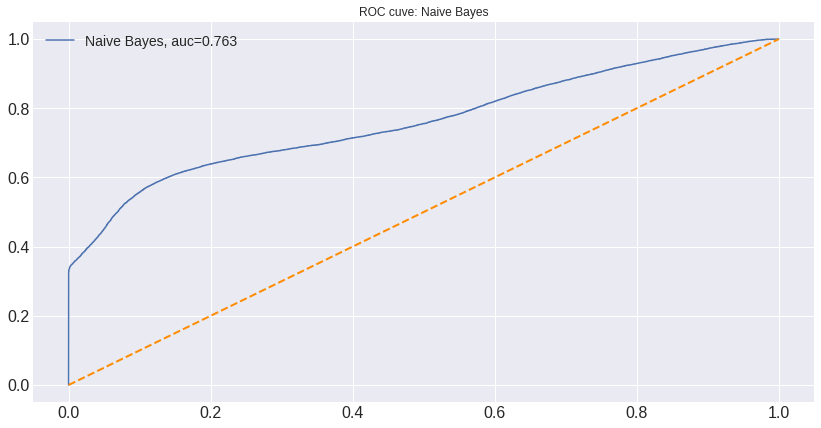

0.763023787609648

In [145]:
roc_curve(nb.predict_proba(X_test)[:,1], y_test, "Naive Bayes")